## Prepare the data

In [11]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
from dys_functions import *

sns.set()

In [26]:
metadata_path = './data/metadata.xlsx'
svc_path = './data/svcs/'
metadata_path_extra = './Dysgraphia-detection-through-machine-learning-main/data2_SciRep_pub.xlsx'
svc_path_extra = './Dysgraphia-detection-through-machine-learning-main/dataSciRep_public/'

data = load_data(metadata_path, metadata_path_extra, svc_path, svc_path_extra)
metadata_new, metadata_extra, svc_data, svc_indexes = data

train_orig = pd.read_csv('train_orig.csv').drop(columns='Unnamed: 0')
train_extra = pd.read_csv('train_extra.csv').drop(columns='Unnamed: 0')
val_orig = pd.read_csv('val_orig.csv').drop(columns='Unnamed: 0')
val_extra = pd.read_csv('val_extra.csv').drop(columns='Unnamed: 0')

train_orig = train_orig.merge(svc_indexes, how='inner', on=['fileindex', 'filename'])
val_orig = val_orig.merge(svc_indexes, how='inner', on=['fileindex', 'filename'])

In [27]:
# carthesian product of (description x tablet inputs x on/off paper) + additional parameters
col_names = column_names()

split_data = [split_on_gaps(series) for series in svc_data]

# prepare the Butterworth filtered dataset
butter_data = [[filter_data(subseries) 
                for subseries in series]
               for series in split_data]

In [28]:
raw_train120, data_index120 = prepare_dynamic_dataset(split_data, 120)

butter_train120, _ = prepare_dynamic_dataset(butter_data, 120)

X_index120 = pd.DataFrame(data_index120, columns=['fileindex']
                                   ).reset_index()

X_train120 = train_orig.merge(X_index120, how='inner', on='fileindex')
y_train120 = X_train120.DYS.astype(int)

X_val120 = val_orig.merge(X_index120, how='inner', on='fileindex')
y_val120 = X_val120.DYS.astype(int)

X_train120_extra = train_extra.merge(X_index120, how='inner', on='fileindex')
y_train120_extra = X_train120_extra.DYS.astype(int)

X_val120_extra = val_extra.merge(X_index120, how='inner', on='fileindex')
y_val120_extra = X_val120_extra.DYS.astype(int)

In [29]:
lstm_raw120 = tf.keras.models.load_model('model_saves/lstm_rawr120.keras')
lstm_butter120 = tf.keras.models.load_model('model_saves/lstm_butter120.keras')
lstm_butter120_extra = tf.keras.models.load_model('model_saves/lstm_butter120_extra.keras')

2023-08-31 10:31:44.577056: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1203 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.20gb, pci bus id: 0000:21:00.0, compute capability: 8.0


In [31]:
X_val120_raw  = np.take(raw_train120, X_val120.index, axis=0).astype(float)
X_val120_butter = np.take(butter_train120, X_val120.index, axis=0).astype(float)
X_val120_butter_extra  = np.take(butter_train120, X_val120_extra.index, axis=0).astype(float)

y_raw120 = lstm_raw120.predict(X_val120_raw)
y_butter120 = lstm_butter120.predict(X_val120_butter)
y_butter120_extra = lstm_butter120_extra.predict(X_val120_butter_extra)

470/470 [==============================] - 3s 6ms/step


## Results analysis

### Baseline

In [99]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train120_extra, y_train120_extra)
y_dummy120_extra = dummy.predict(X_val120_extra)
print(classification_report(y_val120_extra, y_dummy120_extra))
confusion_matrix(y_val120_extra, y_dummy120_extra)

              precision    recall  f1-score   support

           0       0.54      0.46      0.50      8222
           1       0.45      0.54      0.49      6787

    accuracy                           0.49     15009
   macro avg       0.50      0.50      0.49     15009
weighted avg       0.50      0.49      0.49     15009



array([[3743, 4479],
       [3150, 3637]])

### Sequences of length 120

In [40]:
results_orig = pd.concat([
                        pd.DataFrame(np.rint(y_raw120), columns=['pred_raw']),
                        pd.DataFrame(np.rint(y_butter120), columns=['pred_butter']),
                        X_val120.reset_index()], axis=1)

results_extra = pd.concat([
                            pd.DataFrame(np.rint(y_butter120_extra), columns=['pred_raw_extra']),
                            X_val120_extra.reset_index()], axis=1)

In [100]:
results_orig.head(5)

pred_raw  pred_butter  level_0 filename  new_class   age  sex  DYS  tsk_x  \
0       0.0          1.0        0   BR4441          4  10.0  1.0  0.0     10   
1       0.0          1.0        1   BR4441          4  10.0  1.0  0.0     10   
2       0.0          1.0        2   BR4441          4  10.0  1.0  0.0     10   
3       0.0          1.0        3   BR4441          4  10.0  1.0  0.0     10   
4       1.0          1.0        4   BR4441          4  10.0  1.0  0.0     10   

   fileindex tsk_y   index  
0       1459    10  215685  
1       1459    10  215686  
2       1459    10  215687  
3       1459    10  215688  
4       1459    10  215689

In [101]:
from sklearn.metrics import confusion_matrix

print(classification_report(results_orig.pred_raw, results_orig.DYS))
confusion_matrix(results_orig.pred_raw, results_orig.DYS)

              precision    recall  f1-score   support

         0.0       0.59      0.74      0.65     13101
         1.0       0.38      0.24      0.29      8924

    accuracy                           0.53     22025
   macro avg       0.48      0.49      0.47     22025
weighted avg       0.50      0.53      0.51     22025



array([[9665, 3436],
       [6814, 2110]])

In [102]:
print(classification_report(results_orig.pred_butter, results_orig.DYS))
confusion_matrix(results_orig.pred_butter, results_orig.DYS)

              precision    recall  f1-score   support

         0.0       0.45      0.73      0.56     10189
         1.0       0.50      0.23      0.32     11836

    accuracy                           0.46     22025
   macro avg       0.47      0.48      0.44     22025
weighted avg       0.48      0.46      0.43     22025



array([[7407, 2782],
       [9072, 2764]])

In [104]:
print(classification_report(results_extra.pred_raw_extra, results_extra.DYS))
confusion_matrix(results_extra.pred_raw_extra, results_extra.DYS)

              precision    recall  f1-score   support

         0.0       0.21      0.48      0.29      3531
         1.0       0.73      0.43      0.54     11478

    accuracy                           0.44     15009
   macro avg       0.47      0.46      0.42     15009
weighted avg       0.61      0.44      0.48     15009



array([[1704, 1827],
       [6518, 4960]])

In [38]:
results_orig.head(5)

pred_raw  pred_butter  level_0 filename  new_class   age  sex  DYS  tsk_x  \
0       0.0          1.0        0   BR4441          4  10.0  1.0  0.0     10   
1       0.0          1.0        1   BR4441          4  10.0  1.0  0.0     10   
2       0.0          1.0        2   BR4441          4  10.0  1.0  0.0     10   
3       0.0          1.0        3   BR4441          4  10.0  1.0  0.0     10   
4       1.0          1.0        4   BR4441          4  10.0  1.0  0.0     10   

   fileindex tsk_y   index  
0       1459    10  215685  
1       1459    10  215686  
2       1459    10  215687  
3       1459    10  215688  
4       1459    10  215689

In [41]:
results_extra.head(5)

pred_raw_extra  level_0  filename  fileindex  DYS  sex  age   index
0             1.0        0        44       4936    1    1   15  853139
1             1.0        1        44       4936    1    1   15  853140
2             1.0        2        44       4936    1    1   15  853141
3             1.0        3        44       4936    1    1   15  853142
4             1.0        4        44       4936    1    1   15  853143

In [70]:
from ipywidgets import interact

def plot_drawing(x):
    to_plot = raw_train120[x] - np.min(raw_train120[x], axis=0)
    print(raw_train120[x][2][-1])
    to_plot = pd.DataFrame(to_plot, columns=['x', 'y', 'time', 'onpaper', 
                                           'tilt1', 'tilt2', 'pressure'])
    return alt_plot(to_plot)

false_negative = results_extra[results_extra.DYS > results_extra.pred_raw_extra] 
interact(plot_drawing, x=false_negative.index)

interactive(children=(Dropdown(description='x', options=(23, 28, 39, 40, 41, 42, 43, 99, 100, 102, 103, 105, 1…

<function __main__.plot_drawing(x)>

In [87]:
true_positive = results_extra[(results_extra.DYS == results_extra.pred_raw_extra) & (results_extra.DYS == 1)] 
interact(plot_drawing, x=true_positive.index)

interactive(children=(Dropdown(description='x', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

<function __main__.plot_drawing(x)>

In [76]:
true_negative = results_extra[(results_extra.DYS == results_extra.pred_raw_extra) & (results_extra.DYS == 0)] 
interact(plot_drawing, x=true_negative.index)

interactive(children=(Dropdown(description='x', options=(804, 805, 806, 819, 820, 862, 864, 870, 871, 872, 882…

<function __main__.plot_drawing(x)>

In [80]:
false_positive = results_extra[(results_extra.DYS < results_extra.pred_raw_extra)] 
interact(plot_drawing, x=false_positive.index)

interactive(children=(Dropdown(description='x', options=(799, 800, 801, 802, 803, 807, 808, 809, 810, 811, 812…

<function __main__.plot_drawing(x)>

In [89]:
print(false_negative.fileindex.value_counts())
print(true_positive.fileindex.value_counts())
print(false_positive.fileindex.value_counts())
print(true_negative.fileindex.value_counts())

fileindex
4993    949
4972    347
4923    249
4990    245
4936     37
Name: count, dtype: int64
fileindex
4923    1431
4972    1356
4936     762
4990     759
4993     652
Name: count, dtype: int64
fileindex
4964    1632
5022    1149
4952    1147
4966    1131
4962    1012
4959     447
Name: count, dtype: int64
fileindex
4959    574
4964    318
4952    314
4966    310
5022    110
4962     78
Name: count, dtype: int64


#### Typical results

<Axes: xlabel='y_pred', ylabel='Count'>

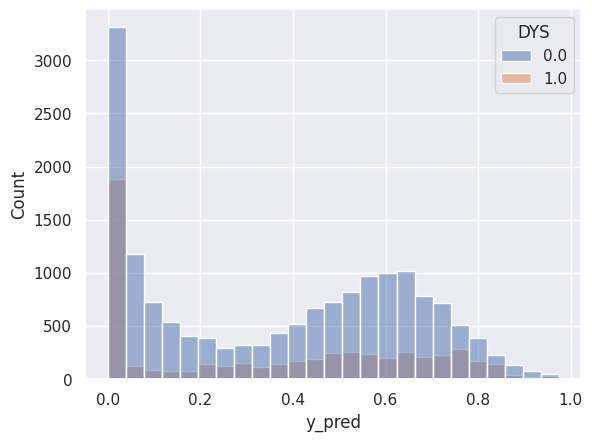

In [110]:
sns.histplot(pd.concat([pd.DataFrame(y_raw120, columns=['y_pred']), X_val120], axis=1), x='y_pred', hue='DYS')

<Axes: >

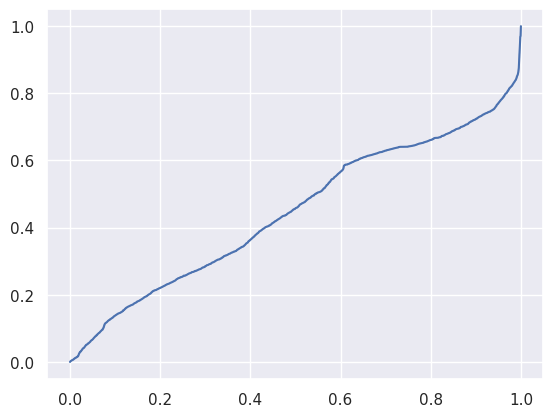

In [122]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_val120, y_raw120)
sns.lineplot(x=fpr, y=tpr)